## Assignment: predicting house prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.


Spend up to 4 hours on this assignment.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
homes_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


homes_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [3]:
homes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [4]:
homes_df = homes_df.rename(columns=lambda x: x.strip())

We have some columns that are numerical and some are non-numerical. This distinction is important because if we like to work with non-numerical variables, we need to convert them to numerical. However, being numerical doesn't mean being continuous or categorical.

In [5]:
non_numeric_columns = homes_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [6]:
numeric_columns = homes_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


#### First lets focus on data cleaning

In [7]:
total_missing = homes_df.isnull().sum().sort_values(ascending=False)
percent_missing = (homes_df.isnull().sum()/homes_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


#### The first five vectors are missing too much data so I will drop them, even the sixth vector is missing a sizable chunk of values so I will drop that one as well. 

In [8]:
homes_df = homes_df.drop(['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'lotfrontage'], axis=1)

### Visualizing Missing Data

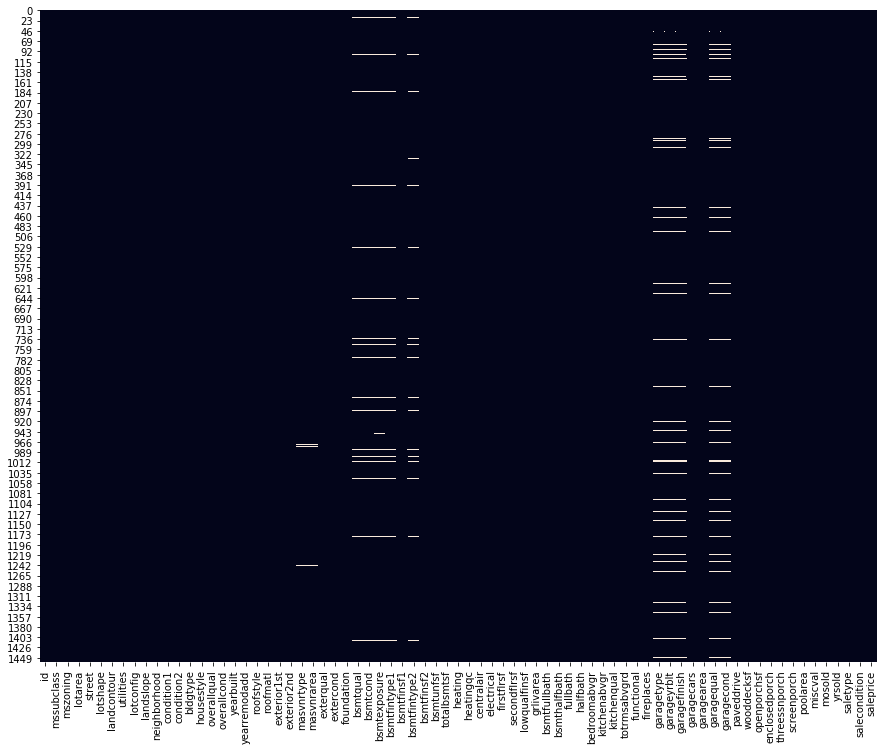

In [9]:
plt.figure(figsize=(15, 12))
sns.heatmap(homes_df.isnull(), cbar=False)

In [10]:
# Deleting missing observations at the row-level
homes_df = homes_df.dropna(axis=0)

### Outlier detection for the numeric columns

In [11]:
# I do not want to modify or include ['id'], into my Outlier handling processing
numeric_columns = numeric_columns.drop(['id'])


In [12]:
FILL_LIST = []
for cols in homes_df[:]:
    if cols in numeric_columns:
        FILL_LIST.append(cols)

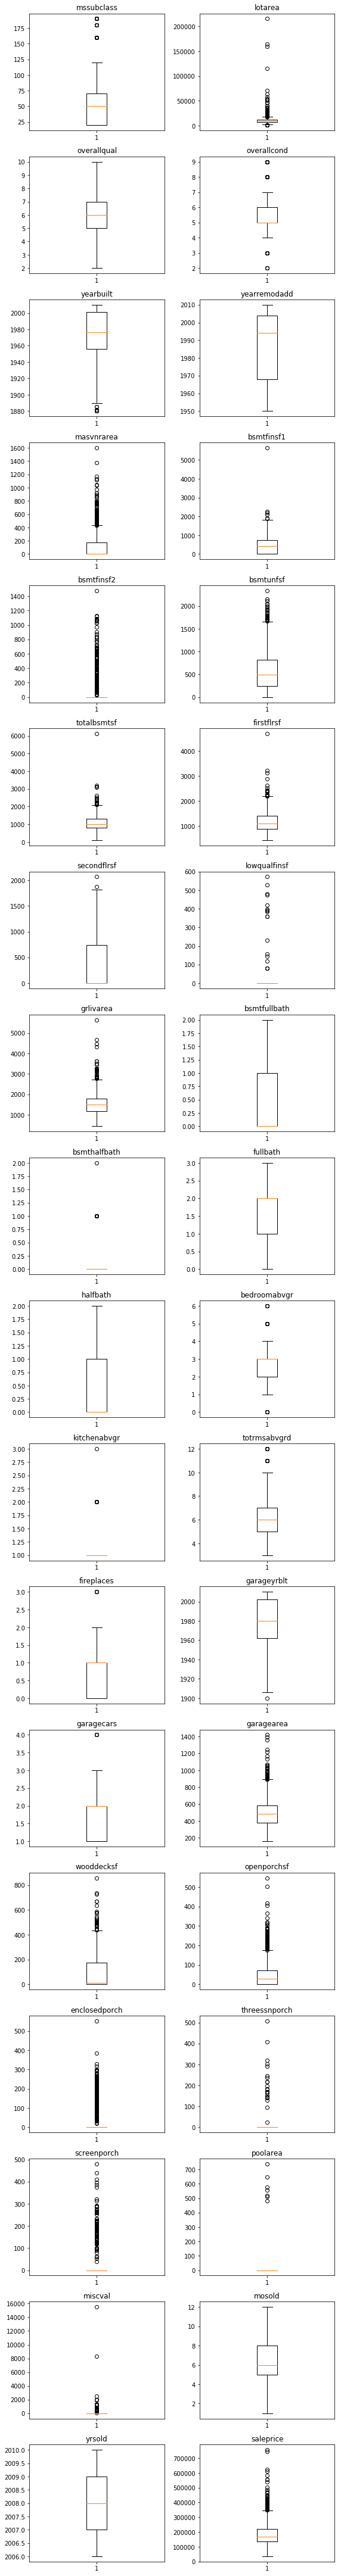

In [13]:
plt.figure(figsize=(8, 120))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    plt.subplot(len(FILL_LIST), 2, i+1)
    plt.boxplot(x=col, data=homes_df.loc[3:], whis=1.5)
    plt.title(col)
    
plt.tight_layout()

There appears to be quite a number of outliers here. I am going to winsorize these columns to limit the influence of outliers in our data set. 

Note that the winsorization taking place is uneven, this is a native way to deal with the skewed distributions and clip the right-tailed outliers. 

### A quick ook at the target: sale price is skewed right. 

Text(0.5, 1.0, 'Target: saleprice ')

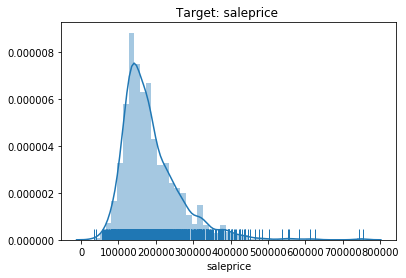

In [14]:
sns.distplot(homes_df.saleprice, rug=True)
plt.title("Target: saleprice ")

In [15]:
from scipy.stats.mstats import winsorize

homes_win = homes_df.copy()

for col in FILL_LIST:
    homes_win[col] = winsorize(homes_win[col], (.05, .14))

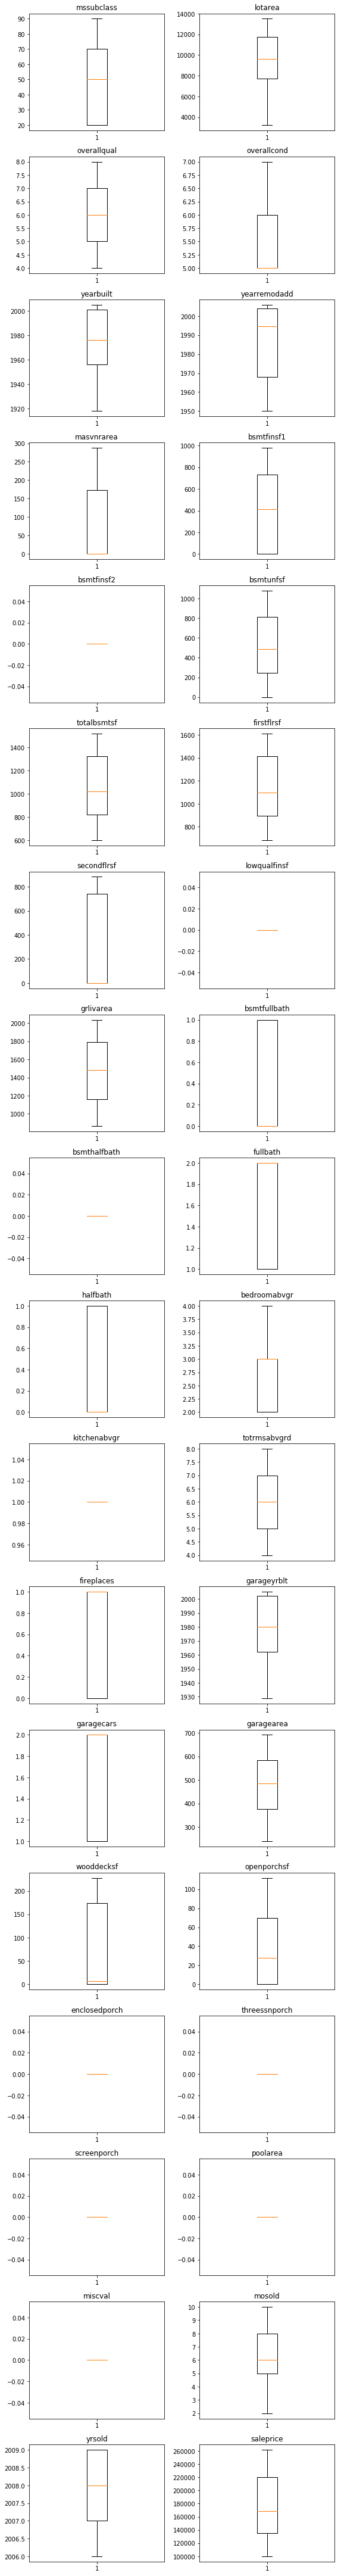

In [16]:
plt.figure(figsize=(8, 120))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    plt.subplot(len(FILL_LIST), 2, i+1)
    plt.boxplot(x=col, data=homes_win[:], whis=1.5)
    plt.title(col)
    
plt.tight_layout()

## Preprocessing 

Now that we have minimized the impact of outliers with winsorization, transform our categorical data into numerical data for our regression model. 

In [17]:
non_numeric_columns

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

In [18]:
from sklearn import preprocessing

def cat_converter(df):
    for cols in df:
        if cols in non_numeric_columns:
            
            # Create a label (category) encoder object
            le = preprocessing.LabelEncoder()
            
            # Create a label (category) encoder object
            le.fit(df[cols])
            
            # Apply the fitted encoder to the pandas column
            df[cols] = le.transform(df[cols]) 
    return df


In [19]:
cat_converter(homes_win)

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,3,8450,1,3,3,0,4,0,...,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,9600,1,3,3,0,2,0,...,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,11250,1,0,3,0,4,0,...,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,9550,1,0,3,0,0,0,...,0,0,0,0,0,2,2006,8,0,140000
4,5,60,3,13518,1,0,3,0,2,0,...,0,0,0,0,0,10,2008,8,4,250000
5,6,50,3,13518,1,0,3,0,4,0,...,0,0,0,0,0,10,2009,8,4,143000
6,7,20,3,10084,1,3,3,0,4,0,...,0,0,0,0,0,8,2007,8,4,261500
7,8,60,3,10382,1,0,3,0,0,0,...,0,0,0,0,0,10,2009,8,4,200000
8,9,50,4,6120,1,3,3,0,4,0,...,0,0,0,0,0,4,2008,8,0,129900
9,10,90,3,7420,1,3,3,0,0,0,...,0,0,0,0,0,2,2008,8,4,118000


### Now that we have all numerical data and we know that we have a regression task at hand we can look to explore which features inform us the most regarding our target sale price

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data = homes_win.iloc[:, 1:-1]
target = homes_win['saleprice']

# Select 5 features with highest chi-squared scores
chi2_selector = SelectKBest(chi2, k=5)
chi2_selector.fit_transform(data, target)

# Get columns to keep
cols = chi2_selector.get_support(indices=True)

X_kbest = pd.DataFrame(chi2_selector.fit_transform(data, target))

# Create new dataframe with only desired columns, or overwrite existing
X_kbest_feat = data.iloc[:,cols]

In [21]:
X_kbest_feat.head()

,lotarea,bsmtfinsf1,bsmtunfsf,secondflrsf,grlivarea
0,8450,706,150,854,1710
1,9600,978,284,0,1262
2,11250,486,434,866,1786
3,9550,216,540,756,1717
4,13518,655,490,882,2036


In [22]:
homes_mod = homes_win[['lotarea', 'bsmtfinsf1', 'bsmtunfsf', 'secondflrsf', 'grlivarea', 'saleprice']]
homes_mod.head()

,lotarea,bsmtfinsf1,bsmtunfsf,secondflrsf,grlivarea,saleprice
0,8450,706,150,854,1710,208500
1,9600,978,284,0,1262,181500
2,11250,486,434,866,1786,223500
3,9550,216,540,756,1717,140000
4,13518,655,490,882,2036,250000


Checking variables for independence

In [23]:
homes_mod.corr()

,lotarea,bsmtfinsf1,bsmtunfsf,secondflrsf,grlivarea,saleprice
lotarea,1.000000,0.159030,0.057064,0.075739,0.417636,0.426524
bsmtfinsf1,0.159030,1.000000,-0.661862,-0.214104,0.040266,0.254677
bsmtunfsf,0.057064,-0.661862,1.000000,0.028146,0.232156,0.155181
secondflrsf,0.075739,-0.214104,0.028146,1.000000,0.624211,0.252575
grlivarea,0.417636,0.040266,0.232156,0.624211,1.000000,0.731764
saleprice,0.426524,0.254677,0.155181,0.252575,0.731764,1.000000


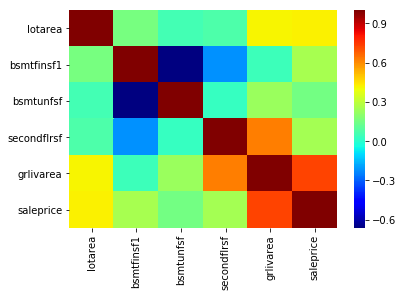

In [24]:
sns.heatmap(homes_mod.corr(), cmap='jet')

#### Variables correlated with each other include bsmtfinsf1 & bsmtunfsf 

    There is more correlation with sale price and bsmtfinsf1 than bsmtunfsf, so I'll keep that vector

In [25]:
homes_mod1 = homes_win[['lotarea', 'bsmtfinsf1', 'secondflrsf', 'grlivarea', 'saleprice']]
homes_mod1.head()

,lotarea,bsmtfinsf1,secondflrsf,grlivarea,saleprice
0,8450,706,854,1710,208500
1,9600,978,0,1262,181500
2,11250,486,866,1786,223500
3,9550,216,756,1717,140000
4,13518,655,882,2036,250000


### Linear Model 

In [26]:
# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

data = homes_mod1.iloc[:, :-1]
target = homes_mod1['saleprice']

# fit method estimates the coefficients using OLS
lrm.fit(data, target)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(data)

results = sm.OLS(target, data).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Fri, 06 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:37:59   Log-Likelihood:                -15754.
No. Observations:                1338   AIC:                         3.152e+04
Df Residuals:                    1334   BIC:                         3.154e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
lotarea         0.9913      0.326      3.045      0.002       0.353       1.630
bsmtfinsf1     21.7550      2.475      8.790      0.000      16.900      26.610
secondflrsf   -33.2301      2.960    -11.227      0.000     -39.037     -27.424
grlivarea     114.4720      2.526     45.309      0.000     109.516     119.428
==============================================================================
Omnibus:                       73.877   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.916
Skew:                          -0.546   Prob(JB):                     2.98e-20
Kurtosis:                       3.650   Cond. No.                         43.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""